In [112]:
%matplotlib inline
import fleks,yt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import numpy as np
import os
import re
from utilities import get_ticks
from matplotlib import cm, ticker
from os import listdir
from os.path import isfile, join
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Save frame slices for making movies

In [77]:
#########################

# High-level user input
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/"    # Directory with data 
start_time = 24                                                # What is the start time of the dataset?
t_bound = [24,36]                                               # Start and stop times for the GIF
dt = 0.2                                                     # What is the timestep between files?

'''
Choose plot type from existing presets;

"pic_E_y":  flow vectors and duskward convective field
Recommended settings: (xy)
xlims=[-2.2,0.2]
ylims=[-1.2,1.2]
shape=[160,160]

"pic_dipolarization_zoom": bz and field lines to show particular dipolarization event in detail
Recommended settings: (xz)
xlims=[-2.2,0.2]
ylims=[-1.2,1.2]
shape=[160,160] 

"pic_currentsheet": eletric field and Bz in current sheet
Recommended settings: (xz)
xlims=[-3.5,0.2]
ylims=[-1.2,1.2]
shape=[160,160] 

"bz1": perturbation magnetic field in near-planet current sheet (xy)
xlims=[-2.4,-0.4]
ylims=[-1,1]
shape=[200,200] 

# "pic_currentsheet2": just bz in the current sheet (xy)
# xlims=[-2.2,0.2]
# ylims=[-1.2,1.2]
# shape=[160,160] 
'''


plot_preset = "bz1"
slice = "xy"                                                   # Set plane of slice ("xy" or "xz") or "sphere" for particle psd
data_type = "cut" # "cut" or "fluid"
z_plane = 0.3

# Grid settings / location of particle sphere
xlims=[-2.4,-0.4]
ylims=[-1,1]
shape=[200,200] 
loc = [-1.0,0,0.2] # location of particle sphere
a = 0.1 # radius of particle sphere

#########################

# First, get list of files in directory
all_files = [os.path.join(dir, o) for o in os.listdir(dir) 
                    if os.path.isdir(os.path.join(dir,o))]

# Then use regex to pick out only the files we want 
files=[]
for file in all_files:
    if data_type=="fluid":
        match = re.search(str(dir+"3d_fluid_region0_.*"),file)
        if match != None:
            files.append(file)
    elif data_type=="cut":
        match = re.search(str(dir+"cut_particle_region0.*"),file)
        if match != None:
            files.append(file)
files.sort()
files = files
print(str(len(files)),"files recognized!")

# Make a dictionary with better names for the files:
named_files = {}
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

# Loop over each file, pull the data, make the plots, and save as .pngs in /frames
for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
    filename = str(named_files[time])
    print(filename)
    ds = fleks.load(filename)
    if slice=="xy":
        dc = ds.get_slice("z",z_plane)
        #print(dc)
    elif slice=="xz":
        dc = ds.get_slice("y",0.0)
    elif slice=="sphere":
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
    
    # Plot!!

    # Use preset
    if plot_preset == "pic_E_y":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        v = dc.evaluate_expression("Ey")
        ux = np.array(dc.evaluate_expression("uxS1").T)
        uy = np.array(dc.evaluate_expression("uyS1").T)
        vmin = v.min().v
        vmax = v.max().v
        nlevels = 200 
        levels = np.linspace(-50, 50, nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(v.T)/1e3, levels=levels, cmap='bwr')
        ticks = get_ticks(-50, 50)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$E_y$ [mV/m]',fontsize=12)
        quiver_skip=10
        ax.quiver(dc.x.value[::quiver_skip], dc.y.value[::quiver_skip],ux[::quiver_skip,::quiver_skip], uy[::quiver_skip,::quiver_skip],color="grey")
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Convection field at t="+str(round(time,2))+"s"))
        fig.show()

    elif plot_preset == "pic_dipolarization_zoom":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        Bx = dc.evaluate_expression("Bx")
        Bz = dc.evaluate_expression("Bz")
        vmin = -100
        vmax = 100
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(Bz.T), levels=levels, cmap='bwr')

        start_points = np.zeros([40,2])
        start_points[:,0]=np.linspace(xlims[0],xlims[1],40)
        start_points[:,1]=0.2
        
        ax.streamplot(dc.x.value,dc.y.value, np.array(Bx.T),np.array(Bz.T),color='grey',linewidth=0.5,broken_streamlines=False,arrowsize=0.5,
                      start_points=start_points)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z$ at t="+str(round(time,2))+"s"))
        fig.show()

    elif plot_preset == "pic_currentsheet":
        fig, ax = plt.subplots(ncols=2,figsize=(25,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        #plot v
        v = np.sqrt(dc.evaluate_expression("uxS1")**2 + dc.evaluate_expression("uyS1")**2)
        ux = np.array(dc.evaluate_expression("uxS1").T)
        uy = np.array(dc.evaluate_expression("uyS1").T)
        vmin = v.min().v
        vmax = v.max().v
        nlevels = 200 
        levels = np.logspace(0, 3, nlevels)
        cs = ax[0].contourf(dc.x.value, dc.y.value, np.array(v.T),levels=levels, cmap='rainbow',locator=ticker.LogLocator())
        clb0 = fig.colorbar(cs, ax=ax[0])                   
        clb0.ax.tick_params(labelsize=8)
        clb0.ax.set_title('$V$ [R$_M$/s]',fontsize=12)
        quiver_skip=10
        ax[0].quiver(dc.x.value[::quiver_skip], dc.y.value[::quiver_skip],ux[::quiver_skip,::quiver_skip], uy[::quiver_skip,::quiver_skip],color="grey")
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Y [$R_M$]")
        ax[0].add_patch(outer)
        ax[0].add_patch(inner)
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].set_title(str("Convection field at t="+str(round(time,2))+"s"))

        #plot B
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        Bx = dc.evaluate_expression("Bx")
        Bz = dc.evaluate_expression("Bz")
        vmin = -100
        vmax = 100
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax[1].contourf(dc.x.value, dc.y.value, np.array(Bz.T), levels=levels, cmap='bwr')
        
        ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs, ax=ax[1],ticks=ticks)            
        clb1.ax.set_yticks(ticks)    
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]")
        ax[1].set_ylabel("Y [$R_M$]")
        ax[1].add_patch(outer)
        ax[1].add_patch(inner)
        ax[1].set_xlim(xlims)
        ax[1].set_ylim(ylims)
        ax[1].set_title(str("$B_z$ at t="+str(round(time,2))+"s"))

    elif plot_preset == "particles_uxuy":
        # broken for many reasons, and the particle data is featureless anyway.
        sp = ds.sphere(loc,a)
        plot = ds.plot_phase_region(sp, 'p_ux', 'p_uz', z_field,
                            unit_type="planet", x_bins=64, y_bins=64,domain_size=(-2550, 2550, -2550, 2550))
        #plot.set_colorbar_label(plot.fields[0], "Ion count")
        for var_name in plot.profile.field_data: 
            val = plot.profile.field_data[var_name] 
    
        x = plot.profile.x
        y = plot.profile.y

        fig, ax = plt.subplots(figsize=(10,10))
        im = ax.contourf(x,y,val,20,vmin = 0,vmax=700)
        im.set_clim(0,700)
        clb=fig.colorbar(im)

    elif plot_preset == "pic_currentsheet2":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        Bz = dc.evaluate_expression("Bz")
        vmin = -100
        vmax = 100
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(Bz.T), levels=levels, cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.2)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z$ at t="+str(round(time,2))+"s"))
        fig.show()

    elif plot_preset == "bz1":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)

        # Extract Bz and remove units
        Bz_temp = dc.evaluate_expression("Bz")
        Bz = np.zeros(Bz_temp.shape)
        Bz[:,:] = Bz_temp[:,:]

        # Define meshgrids
        xx,yy = np.meshgrid(dc.x.value, dc.y.value)

        #Compute Bz1 
        #First compute dipole field strength, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
        Bz_dip = - 200.9 * (3*z_plane**2 - (xx**2+yy**2+z_plane**2))/((xx**2+yy**2+z_plane**2)**(5/2))
        # Then subtract this from modeled bz
        Bz1 = Bz.T - Bz_dip
        
        vmin = -100
        vmax = 100
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(Bz1), levels=levels, cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.2)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z$ at t="+str(round(time,2))+"s"+"   z = "+str(z_plane)))
        fig.show()
    # Save
    plt.savefig(str("/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3_plots/"+plot_preset+"_"+str(round(time,2))+'.png'),bbox_inches='tight')
    plt.close(fig)

yt : [INFO     ] 2024-06-19 11:24:43,121 Parameters: current_time              = 24.000750759910623
yt : [INFO     ] 2024-06-19 11:24:43,122 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:24:43,123 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:24:43,124 Parameters: domain_right_edge         = [1. 2. 2.]


60 files recognized!
/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000024_n00012425_amrex
Plotting t 24.0


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_53908/2154951270.py:329: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
yt : [INFO     ] 2024-06-19 11:24:46,598 Parameters: current_time              = 24.200248161750515
yt : [INFO     ] 2024-06-19 11:24:46,599 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:24:46,600 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:24:46,601 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000024_n00012522_amrex
Plotting t 24.2


yt : [INFO     ] 2024-06-19 11:24:50,466 Parameters: current_time              = 24.401816575227215
yt : [INFO     ] 2024-06-19 11:24:50,467 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:24:50,468 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:24:50,468 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000024_n00012620_amrex
Plotting t 24.4


yt : [INFO     ] 2024-06-19 11:24:54,056 Parameters: current_time              = 24.600719200372804
yt : [INFO     ] 2024-06-19 11:24:54,057 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:24:54,058 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:24:54,058 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000024_n00012725_amrex
Plotting t 24.6


yt : [INFO     ] 2024-06-19 11:24:57,627 Parameters: current_time              = 24.800550083881898
yt : [INFO     ] 2024-06-19 11:24:57,628 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:24:57,628 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:24:57,629 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000024_n00012830_amrex
Plotting t 24.8


yt : [INFO     ] 2024-06-19 11:25:01,303 Parameters: current_time              = 25.000405652917145
yt : [INFO     ] 2024-06-19 11:25:01,304 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:01,304 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:01,305 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000025_n00012932_amrex
Plotting t 25.0


yt : [INFO     ] 2024-06-19 11:25:05,228 Parameters: current_time              = 25.201446911183258
yt : [INFO     ] 2024-06-19 11:25:05,228 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:05,229 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:05,230 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000025_n00013035_amrex
Plotting t 25.2


yt : [INFO     ] 2024-06-19 11:25:08,889 Parameters: current_time              = 25.400793748223922
yt : [INFO     ] 2024-06-19 11:25:08,890 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:08,890 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:08,891 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000025_n00013134_amrex
Plotting t 25.4


yt : [INFO     ] 2024-06-19 11:25:12,563 Parameters: current_time              = 25.600612118378713
yt : [INFO     ] 2024-06-19 11:25:12,564 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:12,564 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:12,565 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000025_n00013236_amrex
Plotting t 25.6


yt : [INFO     ] 2024-06-19 11:25:16,242 Parameters: current_time              = 25.800182186368946
yt : [INFO     ] 2024-06-19 11:25:16,243 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:16,244 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:16,245 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000025_n00013341_amrex
Plotting t 25.8


yt : [INFO     ] 2024-06-19 11:25:20,046 Parameters: current_time              = 26.0000990425917
yt : [INFO     ] 2024-06-19 11:25:20,047 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:20,047 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:20,048 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000026_n00013451_amrex
Plotting t 26.0


yt : [INFO     ] 2024-06-19 11:25:23,500 Parameters: current_time              = 26.20064253569416
yt : [INFO     ] 2024-06-19 11:25:23,501 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:23,502 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:23,502 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000026_n00013557_amrex
Plotting t 26.2


yt : [INFO     ] 2024-06-19 11:25:26,999 Parameters: current_time              = 26.401745647955075
yt : [INFO     ] 2024-06-19 11:25:27,000 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:27,001 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:27,002 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000026_n00013663_amrex
Plotting t 26.4


yt : [INFO     ] 2024-06-19 11:25:30,666 Parameters: current_time              = 26.601536996344475
yt : [INFO     ] 2024-06-19 11:25:30,666 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:30,667 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:30,668 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000026_n00013773_amrex
Plotting t 26.6


yt : [INFO     ] 2024-06-19 11:25:34,315 Parameters: current_time              = 26.800931641264572
yt : [INFO     ] 2024-06-19 11:25:34,316 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:34,316 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:34,317 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000026_n00013878_amrex
Plotting t 26.8


yt : [INFO     ] 2024-06-19 11:25:38,067 Parameters: current_time              = 27.001851867935244
yt : [INFO     ] 2024-06-19 11:25:38,068 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:38,069 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:38,070 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000027_n00013986_amrex
Plotting t 27.0


yt : [INFO     ] 2024-06-19 11:25:41,730 Parameters: current_time              = 27.201229088904807
yt : [INFO     ] 2024-06-19 11:25:41,731 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:41,731 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:41,732 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000027_n00014093_amrex
Plotting t 27.2


yt : [INFO     ] 2024-06-19 11:25:45,344 Parameters: current_time              = 27.400134561488382
yt : [INFO     ] 2024-06-19 11:25:45,345 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:45,345 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:45,346 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000027_n00014203_amrex
Plotting t 27.4


yt : [INFO     ] 2024-06-19 11:25:48,804 Parameters: current_time              = 27.60052457971833
yt : [INFO     ] 2024-06-19 11:25:48,805 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:48,806 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:48,806 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000027_n00014314_amrex
Plotting t 27.6


yt : [INFO     ] 2024-06-19 11:25:52,210 Parameters: current_time              = 27.80114565688377
yt : [INFO     ] 2024-06-19 11:25:52,211 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:52,212 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:52,212 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000027_n00014428_amrex
Plotting t 27.8


yt : [INFO     ] 2024-06-19 11:25:55,872 Parameters: current_time              = 28.000132351650407
yt : [INFO     ] 2024-06-19 11:25:55,873 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:55,874 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:55,874 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000028_n00014537_amrex
Plotting t 28.0


yt : [INFO     ] 2024-06-19 11:25:59,295 Parameters: current_time              = 28.201584486905045
yt : [INFO     ] 2024-06-19 11:25:59,296 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:25:59,297 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:25:59,298 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000028_n00014644_amrex
Plotting t 28.2


yt : [INFO     ] 2024-06-19 11:26:02,648 Parameters: current_time              = 28.400933340928837
yt : [INFO     ] 2024-06-19 11:26:02,649 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:02,650 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:02,650 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000028_n00014752_amrex
Plotting t 28.4


yt : [INFO     ] 2024-06-19 11:26:06,000 Parameters: current_time              = 28.600662160227436
yt : [INFO     ] 2024-06-19 11:26:06,001 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:06,002 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:06,003 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000028_n00014859_amrex
Plotting t 28.6


yt : [INFO     ] 2024-06-19 11:26:09,345 Parameters: current_time              = 28.801701770434263
yt : [INFO     ] 2024-06-19 11:26:09,345 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:09,346 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:09,347 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000028_n00014971_amrex
Plotting t 28.8


yt : [INFO     ] 2024-06-19 11:26:12,774 Parameters: current_time              = 29.000102871361488
yt : [INFO     ] 2024-06-19 11:26:12,774 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:12,775 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:12,776 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000029_n00015082_amrex
Plotting t 29.0


yt : [INFO     ] 2024-06-19 11:26:16,075 Parameters: current_time              = 29.201069039162597
yt : [INFO     ] 2024-06-19 11:26:16,075 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:16,076 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:16,077 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000029_n00015202_amrex
Plotting t 29.2


yt : [INFO     ] 2024-06-19 11:26:19,360 Parameters: current_time              = 29.40148779614541
yt : [INFO     ] 2024-06-19 11:26:19,361 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:19,362 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:19,363 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000029_n00015327_amrex
Plotting t 29.4


yt : [INFO     ] 2024-06-19 11:26:22,558 Parameters: current_time              = 29.600946907764662
yt : [INFO     ] 2024-06-19 11:26:22,559 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:22,559 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:22,560 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000029_n00015450_amrex
Plotting t 29.6


yt : [INFO     ] 2024-06-19 11:26:25,825 Parameters: current_time              = 29.80095247398972
yt : [INFO     ] 2024-06-19 11:26:25,825 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:25,826 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:25,827 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000029_n00015569_amrex
Plotting t 29.8


yt : [INFO     ] 2024-06-19 11:26:29,282 Parameters: current_time              = 30.000771595867985
yt : [INFO     ] 2024-06-19 11:26:29,283 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:29,284 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:29,284 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000030_n00015684_amrex
Plotting t 30.0


yt : [INFO     ] 2024-06-19 11:26:32,409 Parameters: current_time              = 30.201009016391144
yt : [INFO     ] 2024-06-19 11:26:32,410 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:32,410 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:32,411 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000030_n00015797_amrex
Plotting t 30.2


yt : [INFO     ] 2024-06-19 11:26:35,740 Parameters: current_time              = 30.400114488146173
yt : [INFO     ] 2024-06-19 11:26:35,740 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:35,741 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:35,741 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000030_n00015911_amrex
Plotting t 30.4


yt : [INFO     ] 2024-06-19 11:26:38,943 Parameters: current_time              = 30.60092483919582
yt : [INFO     ] 2024-06-19 11:26:38,944 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:38,944 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:38,945 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000030_n00016023_amrex
Plotting t 30.6


yt : [INFO     ] 2024-06-19 11:26:41,967 Parameters: current_time              = 30.800572710509318
yt : [INFO     ] 2024-06-19 11:26:41,968 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:41,969 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:41,970 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000030_n00016130_amrex
Plotting t 30.8


yt : [INFO     ] 2024-06-19 11:26:45,060 Parameters: current_time              = 31.000922941084387
yt : [INFO     ] 2024-06-19 11:26:45,061 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:45,062 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:45,063 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000031_n00016235_amrex
Plotting t 31.0


yt : [INFO     ] 2024-06-19 11:26:48,372 Parameters: current_time              = 31.201024464841005
yt : [INFO     ] 2024-06-19 11:26:48,372 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:48,373 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:48,374 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000031_n00016345_amrex
Plotting t 31.2


yt : [INFO     ] 2024-06-19 11:26:51,372 Parameters: current_time              = 31.400437230431557
yt : [INFO     ] 2024-06-19 11:26:51,373 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:51,374 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:51,374 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000031_n00016454_amrex
Plotting t 31.4


yt : [INFO     ] 2024-06-19 11:26:54,343 Parameters: current_time              = 31.600863973475946
yt : [INFO     ] 2024-06-19 11:26:54,344 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:54,344 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:54,345 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000031_n00016561_amrex
Plotting t 31.6


yt : [INFO     ] 2024-06-19 11:26:57,295 Parameters: current_time              = 31.800940933457053
yt : [INFO     ] 2024-06-19 11:26:57,296 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:26:57,296 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:26:57,297 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000031_n00016670_amrex
Plotting t 31.8


yt : [INFO     ] 2024-06-19 11:27:00,378 Parameters: current_time              = 32.00045381002094
yt : [INFO     ] 2024-06-19 11:27:00,379 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:00,379 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:00,380 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000032_n00016780_amrex
Plotting t 32.0


yt : [INFO     ] 2024-06-19 11:27:03,253 Parameters: current_time              = 32.20154146579887
yt : [INFO     ] 2024-06-19 11:27:03,253 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:03,254 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:03,255 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000032_n00016892_amrex
Plotting t 32.2


yt : [INFO     ] 2024-06-19 11:27:06,635 Parameters: current_time              = 32.40106040495361
yt : [INFO     ] 2024-06-19 11:27:06,636 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:06,636 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:06,637 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000032_n00017025_amrex
Plotting t 32.4


yt : [INFO     ] 2024-06-19 11:27:09,637 Parameters: current_time              = 32.600894675213404
yt : [INFO     ] 2024-06-19 11:27:09,638 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:09,639 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:09,639 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000032_n00017172_amrex
Plotting t 32.6


yt : [INFO     ] 2024-06-19 11:27:12,716 Parameters: current_time              = 32.8004237172701
yt : [INFO     ] 2024-06-19 11:27:12,717 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:12,718 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:12,719 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000032_n00017305_amrex
Plotting t 32.8


yt : [INFO     ] 2024-06-19 11:27:15,981 Parameters: current_time              = 33.00116375570979
yt : [INFO     ] 2024-06-19 11:27:15,981 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:15,982 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:15,983 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000033_n00017430_amrex
Plotting t 33.0


yt : [INFO     ] 2024-06-19 11:27:19,229 Parameters: current_time              = 33.20162689580065
yt : [INFO     ] 2024-06-19 11:27:19,230 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:19,231 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:19,232 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000033_n00017547_amrex
Plotting t 33.2


yt : [INFO     ] 2024-06-19 11:27:22,402 Parameters: current_time              = 33.40141110067697
yt : [INFO     ] 2024-06-19 11:27:22,402 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:22,403 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:22,404 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000033_n00017669_amrex
Plotting t 33.4


yt : [INFO     ] 2024-06-19 11:27:25,642 Parameters: current_time              = 33.600937997114265
yt : [INFO     ] 2024-06-19 11:27:25,643 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:25,644 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:25,644 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000033_n00017800_amrex
Plotting t 33.6


yt : [INFO     ] 2024-06-19 11:27:29,428 Parameters: current_time              = 33.801459946445505
yt : [INFO     ] 2024-06-19 11:27:29,429 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:29,430 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:29,430 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000033_n00017928_amrex
Plotting t 33.8


yt : [INFO     ] 2024-06-19 11:27:33,170 Parameters: current_time              = 34.00063787319218
yt : [INFO     ] 2024-06-19 11:27:33,171 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:33,172 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:33,173 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000034_n00018047_amrex
Plotting t 34.0


yt : [INFO     ] 2024-06-19 11:27:37,230 Parameters: current_time              = 34.20062036895042
yt : [INFO     ] 2024-06-19 11:27:37,231 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:37,232 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:37,233 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000034_n00018168_amrex
Plotting t 34.2


yt : [INFO     ] 2024-06-19 11:27:41,208 Parameters: current_time              = 34.40122049673846
yt : [INFO     ] 2024-06-19 11:27:41,209 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:41,210 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:41,211 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000034_n00018289_amrex
Plotting t 34.4


yt : [INFO     ] 2024-06-19 11:27:45,146 Parameters: current_time              = 34.60118078064689
yt : [INFO     ] 2024-06-19 11:27:45,147 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:45,148 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:45,150 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000034_n00018409_amrex
Plotting t 34.6


yt : [INFO     ] 2024-06-19 11:27:49,064 Parameters: current_time              = 34.80053468618632
yt : [INFO     ] 2024-06-19 11:27:49,065 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:49,066 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:49,067 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000034_n00018534_amrex
Plotting t 34.8


yt : [INFO     ] 2024-06-19 11:27:52,830 Parameters: current_time              = 35.00070846321112
yt : [INFO     ] 2024-06-19 11:27:52,832 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:52,833 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:52,834 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000035_n00018665_amrex
Plotting t 35.0


yt : [INFO     ] 2024-06-19 11:27:56,769 Parameters: current_time              = 35.201692510453135
yt : [INFO     ] 2024-06-19 11:27:56,770 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:27:56,771 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:27:56,772 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000035_n00018791_amrex
Plotting t 35.2


yt : [INFO     ] 2024-06-19 11:28:01,056 Parameters: current_time              = 35.40074086558089
yt : [INFO     ] 2024-06-19 11:28:01,057 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:28:01,058 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:28:01,059 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000035_n00018910_amrex
Plotting t 35.4


yt : [INFO     ] 2024-06-19 11:28:04,906 Parameters: current_time              = 35.60028006019205
yt : [INFO     ] 2024-06-19 11:28:04,907 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:28:04,908 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:28:04,909 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000035_n00019031_amrex
Plotting t 35.6


yt : [INFO     ] 2024-06-19 11:28:08,771 Parameters: current_time              = 35.800642268700194
yt : [INFO     ] 2024-06-19 11:28:08,773 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 11:28:08,773 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 11:28:08,774 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3/cut_particle_region0_0_t00000035_n00019150_amrex
Plotting t 35.8


In [73]:
Bz_dip.shape

(256, 320)

# Particle data plotting


yt : [INFO     ] 2024-06-19 17:20:37,629 Parameters: current_time              = 30.000771595867985
yt : [INFO     ] 2024-06-19 17:20:37,630 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:37,631 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:37,632 Parameters: domain_right_edge         = [1. 2. 2.]


Plotting all files in dir
Plotting t = 24.0


yt : [WARNING  ] 2024-06-19 17:20:37,829 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-06-19 17:20:37,894 Parameters: current_time              = 30.000771595867985
yt : [INFO     ] 2024-06-19 17:20:37,894 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:37,895 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:37,896 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-06-19 17:20:38,062 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-06-19 17:20:38,580 Parameters: current_time              = 24.000750759910623
yt : [INFO     ] 2024-06-19 17:20:38,581 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:38,582 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:38,5

Plotting t = 24.2


yt : [INFO     ] 2024-06-19 17:20:38,783 Parameters: current_time              = 24.000750759910623
yt : [INFO     ] 2024-06-19 17:20:38,784 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:38,785 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:38,785 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-06-19 17:20:38,917 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-06-19 17:20:39,145 Parameters: current_time              = 24.200248161750515
yt : [INFO     ] 2024-06-19 17:20:39,146 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:39,147 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:39,148 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-06-19 17:20:39,299 Field ('particle', 'unit_one') was added without s

Plotting t = 24.4


yt : [INFO     ] 2024-06-19 17:20:39,373 Parameters: current_time              = 24.200248161750515
yt : [INFO     ] 2024-06-19 17:20:39,373 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:39,374 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:39,375 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-06-19 17:20:39,500 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-06-19 17:20:39,726 Parameters: current_time              = 24.401816575227215
yt : [INFO     ] 2024-06-19 17:20:39,727 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:39,728 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:39,729 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-06-19 17:20:39,885 Field ('particle', 'unit_one') was added without s

Plotting t = 24.6


yt : [INFO     ] 2024-06-19 17:20:39,957 Parameters: current_time              = 24.401816575227215
yt : [INFO     ] 2024-06-19 17:20:39,958 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:39,958 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:39,959 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-06-19 17:20:40,464 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-06-19 17:20:40,679 Parameters: current_time              = 24.600719200372804
yt : [INFO     ] 2024-06-19 17:20:40,680 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:40,681 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:40,681 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-06-19 17:20:40,829 Field ('particle', 'unit_one') was added without s

Plotting t = 24.8


yt : [INFO     ] 2024-06-19 17:20:40,906 Parameters: current_time              = 24.600719200372804
yt : [INFO     ] 2024-06-19 17:20:40,907 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-06-19 17:20:40,908 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-06-19 17:20:40,908 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-06-19 17:20:41,055 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3
vx_vy-vx_vz*
[]


IndexError: list index out of range

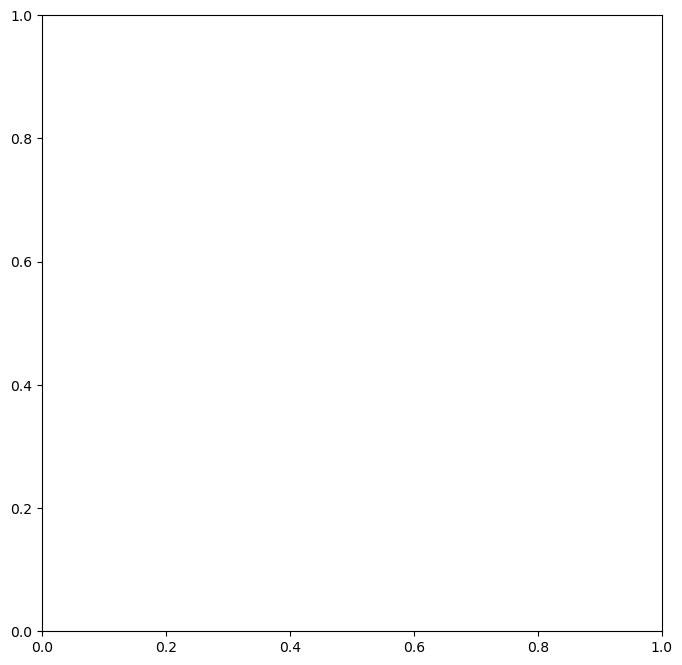

In [118]:
####### START USER INPUT ###########
folder = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run3/ta-3"
file = "cut_particle_region0_0_t00000031_n00016670_amrex/"
loc=[-1.80,-0.42,0.30]  # Location of sphere to sample particles in
radius=(0.05)  # Size of sphere
plot_preset = "vx_vy-vx_vz"
multi = True # Loop through files and save multiple panels?
start_time = 24            # What is the earliest time saved in this directory?
t_bound = [24,25]                # Start and stop times to loop through
dt = 0.2  # time step between files
make_gif = False    # whether to save a gif. Not working at the moment
####### END USER INPUT ###########
dir = str(folder+"/")
""" 
PRESETS:
vx_vy-vx_vz: plot of raw particle velocity distribution at loc, using standard values for controls. 

"""

# Make a dictionary with better names for the files:
named_files = {}
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

def get_directories(dir, key=".*_particle_region0.*"):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    all_files = [ f.name for f in os.scandir(dir) if f.is_dir() ]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    # Now give them the appropriate name for their time
    named_files = {}
    for i in range(len(files)):
        time = round(i*dt+start_time,3)
        named_files[time] = files[i]
    # Now cut the list down to files inside t_bound
    reduced_files = {}
    for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
        reduced_files[time] = str(named_files[time])
    return reduced_files

def _unit_one(field, data):
    res = np.zeros(data[('particle', 'p_w')].shape)
    res[:] = 1
    return res

def get_particle_np(file, x_axis='p_ux', y_axis='p_uy', bins=64, v_lim = 2500):
    # Get the particle distribution in numpy format.
    # File is the directory of the amrex folder (e.g. /Users/*_amrex/"
    # x_axis and y_axis are what quantities to extract e.g. 'p_x','p_y'
    # Bins is how many bins to divide into
    # v_lim is the maximum velocity to extract (in km/s)
    # Outputs the meshgrids of velocities (in km/s), and the number of particles in each of those grid cells

    # Load the file
    ds = fleks.load(file)

    # Do some stuff I don't totally understand
    ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
    sp = ds.sphere(loc,radius)
    z_field = 'unit_one'
    plot = ds.plot_phase_region(sp, x_axis, y_axis, z_field, unit_type="planet", 
                                    x_bins=bins, y_bins=bins, domain_size=(-v_lim, v_lim, -v_lim, v_lim))

    for var_name in plot.profile.field_data: 
        counts_temp = plot.profile.field_data[var_name].T # take the transpose, which seems to be necessary. Bit worried about that.

    # Define output arrays without units
    x_temp = plot.profile.x
    y_temp = plot.profile.y
    x=np.zeros(x_temp.shape)
    y=np.zeros(y_temp.shape)
    counts=np.zeros(counts_temp.shape)
    x[:]=x_temp[:]
    y[:]=y_temp[:]
    counts[:,:]=counts_temp[:,:]
    xx,yy=np.meshgrid(x,y)

    return xx,yy,counts

def generate_gif(folder, key=str(plot_preset+"*")):
    #read all the .png files in directory "frames" 
    print(folder)
    print(key)
    gif_files = glob.glob(str(folder+"/"+key))
    print(gif_files)
    image_array = []
    gif_files = natsorted(gif_files)
    
    for my_file in gif_files:
        image = Image.open(gif_files)
        image_array.append(image)
        
    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)
    plt.axis('off')
    
    def update(i):
        im.set_array(image_array[i])
        return im, 
    
    # Create the animation object
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)
    
    animation_fig.save(str(folder+"_plots/"+"animated.gif"),dpi=500)
    plt.close(fig)

def particle_plots(mode):
    # Generates the desired plot for the given preset.

    if mode == "vx_vy-vx_vz":
        # Define the files to read
        if multi:
            print("Plotting all files in dir")
            files = get_directories(dir)
        else:
            files = {str(round(start_time,3)):str(file)}

        # Loop over the identified files
        for time in list(files.keys()): 
            print("Plotting t =",time)
            file = str(files[time])
        
            # Get data
            data_file = dir+file
            xx,yy,counts_xy = get_particle_np(data_file,'p_ux','p_uy')
            xx,zz,counts_xz = get_particle_np(data_file,'p_ux','p_uz')
    
            # Set colorbar limits
            cmin = 1
            cmax = 100#max(counts_xy.max(),counts_xz.max())
    
            # Plot
            fig, axs = plt.subplots(ncols=2,figsize=(13,5))
            im0=axs[0].imshow(counts_xy, extent=[xx.min(), xx.max(), yy.min(), yy.max()],origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
            im1=axs[1].imshow(counts_xz, extent=[xx.min(), xx.max(), zz.min(), zz.max()],origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
    
            # Add labels
            axs[0].set_xlabel("$v_x$ [km/s]")
            axs[0].set_ylabel("$v_y$ [km/s]")
            axs[1].set_xlabel("$v_x$ [km/s]")
            axs[1].set_ylabel("$v_z$ [km/s]")
            axs[0].set_title(str("Velocity distribution  r="+str(loc)+"   t="+str(round(time,2))+"s"))
    
            # Add grid
            axs[0].grid(alpha=0.5)
            axs[1].grid(alpha=0.5)
    
            # Add colorbar
            fig.subplots_adjust(right=0.84)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
            fig.colorbar(im1, cax=cbar_ax, label = "Counts")
    
            # Save
            fig.savefig(str(folder+"_plots/"+plot_preset+"_"+str(loc)+"_"+str(round(time,2))+'.png'),bbox_inches='tight')

            if multi:
                plt.close()

            else:
                plt.show()
        
        if make_gif:
            generate_gif(folder)
# Run
particle_plots(plot_preset)